# Supervised Learning Flow – Titanic Survival Prediction  

**Students:** Yarin S. (ID: 8635)
             Shahaf L. (ID: 8284)

### Introduction
In this assignment we worked on a complete supervised learning flow using the Titanic dataset.
Our goal was to build a model that predicts whether a passenger survived (1) or not (0).

### Tools and Assistance Used
While preparing this assignment we reviewed some online resources.
We also used ChatGPT as a study aid – it helped us understand how cross-validation works,
how to evaluate models with the F1 score, and the importance of comparing algorithms such as Logistic Regression and Decision Tree.

some prompts we used:
When should I prefer F1 over Accuracy on imbalanced data, and why?

Why use solver="liblinear" for Logistic Regression, and what’s the difference between L1 vs L2 penalties?

Best practices for 5-fold StratifiedKFold with reproducibility (e.g., shuffle=True, fixed random_state).

Trade-offs and sensible ranges for Decision Tree hyperparameters (max_depth, min_samples_split) and LR C.

Which EDA plots are most informative for Titanic (Sex, Pclass, Age bins) and what trends should I expect?

In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.tree import DecisionTreeClassifier


## 1. Data Loading and Initial Exploration

In [13]:
# Load train and test data 
train_df = pd.read_csv("titanic_train.csv")
test_df = pd.read_csv("titanic_test.csv")

# Display first 5 rows
display(train_df.head())
display(test_df.head())


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


## 2. Exploratory Data Analysis (EDA)

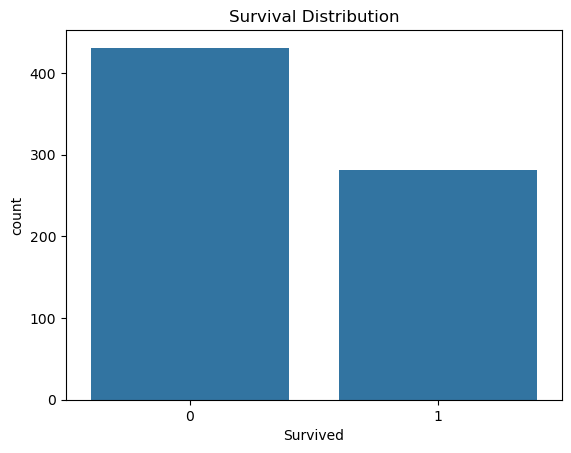

In [14]:
# survival distribution
sns.countplot(x="Survived", data=train_df)
plt.title("Survival Distribution")
plt.show()


*This plot shows the overall survival distribution – most passengers did not survive.*

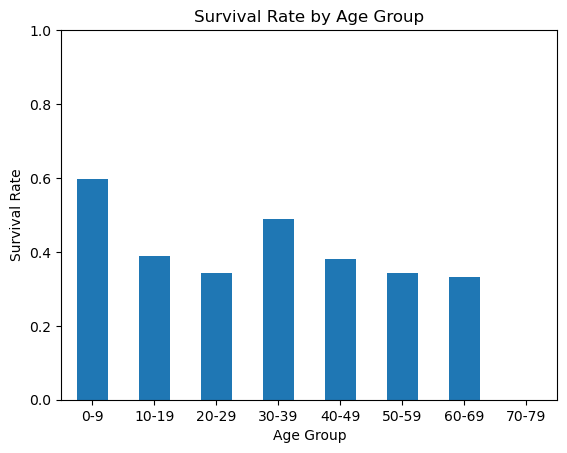

In [15]:
# Survival by Age 
df_age = train_df[['Age', 'Survived']].dropna().copy()

bins = list(range(0, 81, 10))  # 0-9, 10-19, ... 70-79
labels = [f"{i}-{i+9}" for i in bins[:-1]]
df_age['AgeBin'] = pd.cut(df_age['Age'], bins=bins, labels=labels, right=False)

age_grp = df_age.groupby('AgeBin', observed=False)['Survived'].mean()

plt.figure()
age_grp.plot(kind='bar')
plt.title("Survival Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Survival Rate")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.show()


*Survival is highest for children (0–9), roughly average through teens–30s, and declines after 50—lowest in the 70–79 bin.*

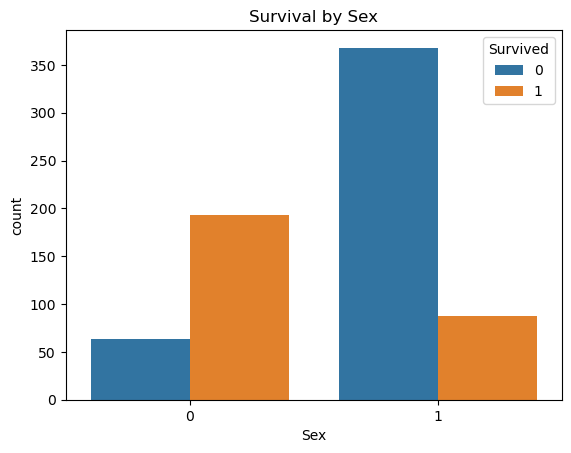

In [16]:
# survival by sex
sns.countplot(x="Sex", hue="Survived", data=train_df)
plt.title("Survival by Sex")
plt.show()


*This plot shows survival by gender – women had a much higher survival rate than men.*

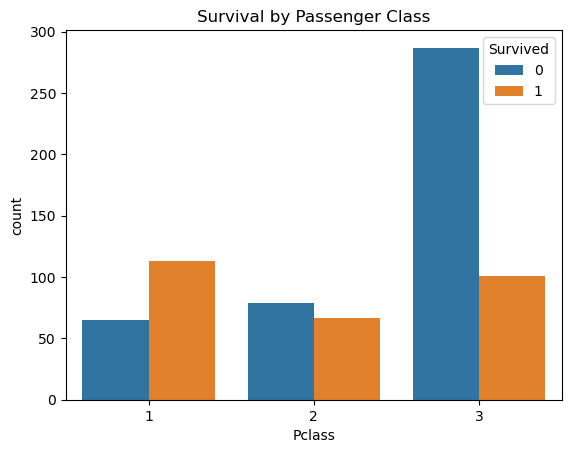

In [17]:
# survival by Pclass
sns.countplot(x="Pclass", hue="Survived", data=train_df)
plt.title("Survival by Passenger Class")
plt.show()


*This plot shows survival by passenger class – first class passengers survived more often than those in lower classes.*

## 3. Feature Engineering and Preprocessing

In [18]:
# Feature Engineering: One-hot only for Pclass and Embarked (Sex already binary)
train_df = pd.get_dummies(train_df, columns=["Pclass", "Embarked"], drop_first=True)
test_df = pd.get_dummies(test_df, columns=["Pclass", "Embarked"], drop_first=True)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Build X, y and align test columns to train columns
X = train_df.drop("Survived", axis=1)
y = train_df["Survived"]
X_test_final = test_df.reindex(columns=X.columns, fill_value=0)

print("Feature matrix shape:", X.shape)
print("Test matrix shape:", X_test_final.shape)
print("Feature columns:", list(X.columns))


Train shape: (712, 11)
Test shape: (179, 11)
Feature matrix shape: (712, 10)
Test matrix shape: (179, 10)
Feature columns: ['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3', 'Embarked_1', 'Embarked_2', 'Embarked_3']


### 3a. Feature-Engineering Experiment: With vs. Without Standardization
We compare Logistic Regression **with** and **without** `StandardScaler` on numeric features (`Age`, `SibSp`, `Parch`, `Fare`) using 5-fold CV and F1.

In [19]:
numeric_cols = [c for c in ["Age","SibSp","Parch","Fare"] if c in X.columns]

# Baseline LR 
baseline_lr = LogisticRegression(max_iter=1000, solver="liblinear", C=1.0)

pipe_no_scale = Pipeline([("model", baseline_lr)])
ct = ColumnTransformer([("num", StandardScaler(), numeric_cols)], remainder="passthrough")
pipe_scaled  = Pipeline([("ct", ct), ("model", baseline_lr)])

scores_no    = cross_val_score(pipe_no_scale, X, y, cv=5, scoring=make_scorer(f1_score), n_jobs=-1)
scores_scale = cross_val_score(pipe_scaled,  X, y, cv=5, scoring=make_scorer(f1_score), n_jobs=-1)

print("Mean F1 (no standardization):       ", round(scores_no.mean(), 4))
print("Mean F1 (with StandardScaler on num):", round(scores_scale.mean(), 4))


Mean F1 (no standardization):        0.7335
Mean F1 (with StandardScaler on num): 0.7342


## 4. Model Training and Experiments

In [20]:

# Cross-validation + metric
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)    
scorer = make_scorer(f1_score, pos_label=1)                        

specs = [
    ("LogisticRegression",
     LogisticRegression(max_iter=1000, solver="liblinear", random_state=42),
     {
         "pre": [StandardScaler(), "passthrough"],                
         "clf__C": [0.1, 1, 10],                                 
         "clf__penalty": ["l1", "l2"],                            
     }),
    ("DecisionTree",
     DecisionTreeClassifier(random_state=42),
     {
         "pre": [StandardScaler(), "passthrough"],                
         "clf__max_depth": [3, 5, None],                           
         "clf__min_samples_split": [2, 5, 10],                   
     }),
]

#Run grid-search per model and collect CV results
frames = []
for name, est, grid in specs:
    # Pipeline: 
    pipe = Pipeline([("pre", "passthrough"), ("clf", est)])

    # Grid search over the pipeline parameters
    gs = GridSearchCV(pipe, grid, cv=cv, scoring=scorer, n_jobs=-1, return_train_score=False)
    gs.fit(X, y)

    # Keep params, mean test score, and the 5 per-fold test scores
    df = pd.DataFrame(gs.cv_results_)[["params", "mean_test_score"] + [f"split{i}_test_score" for i in range(5)]]
    df["Model"] = name
    frames.append(df)

# Concatenate results from both models
results_df = pd.concat(frames, ignore_index=True)

fold_cols = [f"Fold{i} F1" for i in range(1, 6)]
results_df.rename(
    columns={"mean_test_score": "Mean F1", **{f"split{i}_test_score": fold_cols[i] for i in range(5)}},
    inplace=True
)

# Sort by mean F1 (best first)
results_sorted = results_df.sort_values("Mean F1", ascending=False).reset_index(drop=True)

def tidy_params(p: dict) -> dict:
    """Make params compact for printing:
    - scaler: 'std' if StandardScaler, else 'none'
    - drop the 'clf__' prefix from model hyperparameters
    """
    p = p.copy()
    scaler = "std" if isinstance(p.get("pre", "passthrough"), StandardScaler) else "none"
    clean = {"scaler": scaler}
    clean.update({k.replace("clf__", ""): v for k, v in p.items() if k.startswith("clf__")})
    return clean

pretty = results_sorted.copy()
pretty[fold_cols + ["Mean F1"]] = pretty[fold_cols + ["Mean F1"]].astype(float).round(3)
pretty["params"] = pretty["params"].map(tidy_params)
pretty = pretty[["Model", "params"] + fold_cols + ["Mean F1"]]

print("All experiment results (5-fold Stratified CV) — top 20:\n")
print(pretty.head(20).to_string(index=False))


best_overall = results_sorted.loc[0, ["Model", "params", "Mean F1"]]  # 'params' is RAW dict from GridSearch
print("\nBest configuration overall:\n", best_overall.to_string())


pretty.to_csv("gridsearch_5fold_results.csv", index=False)


All experiment results (5-fold Stratified CV) — top 20:

             Model                                                         params  Fold1 F1  Fold2 F1  Fold3 F1  Fold4 F1  Fold5 F1  Mean F1
      DecisionTree     {'scaler': 'none', 'max_depth': 5, 'min_samples_split': 5}     0.755     0.713     0.807     0.642     0.747    0.733
      DecisionTree      {'scaler': 'std', 'max_depth': 5, 'min_samples_split': 5}     0.755     0.713     0.807     0.642     0.747    0.733
      DecisionTree     {'scaler': 'std', 'max_depth': 5, 'min_samples_split': 10}     0.755     0.713     0.807     0.642     0.747    0.733
      DecisionTree    {'scaler': 'none', 'max_depth': 5, 'min_samples_split': 10}     0.755     0.713     0.807     0.642     0.747    0.733
      DecisionTree     {'scaler': 'none', 'max_depth': 5, 'min_samples_split': 2}     0.755     0.713     0.796     0.667     0.733    0.733
      DecisionTree      {'scaler': 'std', 'max_depth': 5, 'min_samples_split': 2}     0.755     0

## 5. Train Best Model

In [21]:
# 5. Train Best Model

model_name = best_overall["Model"]
best_params = best_overall["params"]   

base = (LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)
        if model_name == "LogisticRegression"
        else DecisionTreeClassifier(random_state=42))

final_model = Pipeline([("pre", "passthrough"), ("clf", base)])
final_model.set_params(**best_params) 
final_model.fit(X, y)

print("\nFinal model trained on full trainset.")
print("Model:", model_name)
print("Best hyperparameters:", best_params)



Final model trained on full trainset.
Model: DecisionTree
Best hyperparameters: {'clf__max_depth': 5, 'clf__min_samples_split': 5, 'pre': 'passthrough'}


## 6. Evaluation on Test Set

Test F1: 0.7544
First 5 predictions: [0 0 0 1 0]
First 5 reality: [0 0 0 0 1]


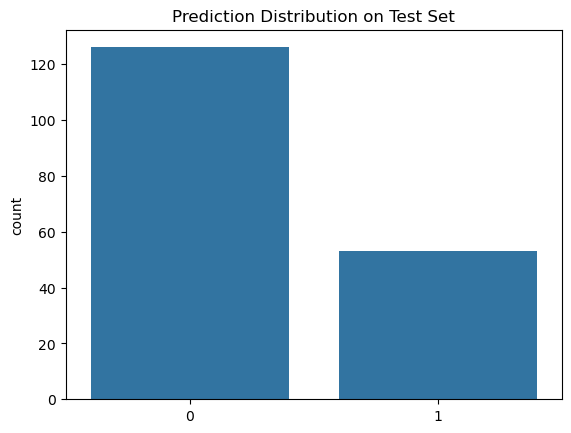

Submission file saved: titanic_predictions_final.csv


In [22]:
# Predict on test set
test_predictions = final_model.predict(X_test_final)

from sklearn.metrics import f1_score
Test_F1 = f1_score(test_df['Survived'], test_predictions)
print(f'Test F1: {Test_F1:.4f}')

# Preview (exactly two lines)
print("First 5 predictions:", np.array(test_predictions[:5]))
print("First 5 reality:", np.array(test_df["Survived"].iloc[:5]))


# Prediction distribution
sns.countplot(x=test_predictions)
plt.title("Prediction Distribution on Test Set")
plt.show()

passenger_ids = np.arange(1, len(test_predictions)+1)
passenger_ids = np.arange(1, len(test_predictions)+1)
submission = pd.DataFrame({"PassengerId": passenger_ids, "Survived": test_predictions})
submission.to_csv("titanic_predictions_final.csv", index=False)
print("Submission file saved: titanic_predictions_final.csv")